In [137]:
import requests
import time
import re

TWSE_URL = 'http://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json'


def get_web_content(stock_id, current_date):
    resp = requests.get(TWSE_URL + '&date=' + current_date + '&stockNo=' + stock_id)
    if resp.status_code != 200:
        return None
    else:
        return resp.json()


def get_data(stock_id, current_date):
    info = []
    resp = get_web_content(stock_id, current_date)
    if resp is None:
        return None
    else:
        if resp['data']:
            for data in resp['data']:
                record = {
                    '日期': data[0],
                    '開盤價': data[3],
                    '收盤價': data[6],
                    '成交筆數': data[8]
                }
                info.append(record)
        return info


def main():
    stock_id = '00861'
    current_date = time.strftime('%Y%m%d')
    current_year = time.strftime('%Y')
    current_month = time.strftime('%m')
    print('Processing data for %s %s...' % (current_year, current_month))
    get_data(stock_id, current_date)
    collected_info = get_data(stock_id, current_date)
#     print(collected_info)
    for info in collected_info:
        print(info)


if __name__ == '__main__':
    main()

Processing data for 2021 05...
{'日期': '110/05/03', '開盤價': '28.98', '收盤價': '28.66', '成交筆數': '421'}
{'日期': '110/05/04', '開盤價': '28.40', '收盤價': '28.44', '成交筆數': '897'}
{'日期': '110/05/05', '開盤價': '28.27', '收盤價': '28.24', '成交筆數': '548'}
{'日期': '110/05/06', '開盤價': '28.25', '收盤價': '28.30', '成交筆數': '423'}
{'日期': '110/05/07', '開盤價': '28.50', '收盤價': '28.62', '成交筆數': '505'}
{'日期': '110/05/10', '開盤價': '28.84', '收盤價': '28.67', '成交筆數': '246'}
{'日期': '110/05/11', '開盤價': '28.08', '收盤價': '27.83', '成交筆數': '1,032'}
{'日期': '110/05/12', '開盤價': '27.60', '收盤價': '27.63', '成交筆數': '1,576'}
{'日期': '110/05/13', '開盤價': '27.10', '收盤價': '27.12', '成交筆數': '1,135'}
{'日期': '110/05/14', '開盤價': '27.12', '收盤價': '27.61', '成交筆數': '785'}
{'日期': '110/05/17', '開盤價': '27.35', '收盤價': '27.75', '成交筆數': '1,147'}


In [39]:
from urllib.request import urlopen
import pandas as pd
import datetime
import requests
import sched
import time
import json
def stock_crawler(targets):
    
#     clear_output(wait=True)
    
    # 組成stock_list
    stock_list = '|'.join('tse_{}.tw'.format(target) for target in targets) 
#     print(stock_list)
    #　query data
    query_url = "http://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch="+ stock_list
    print(query_url)
    data = json.loads(urlopen(query_url).read())

    # 過濾出有用到的欄位
    columns = ['c','n','z','tv','v','o','h','l','y']
    # 有時候抓不到當盤成交價，用最低賣家取代，並用0取代當盤成交量
    for i in data['msgArray']:
        print(i['z'])
        if i['z'] == '-':
            i['z'] = i['a'].split('_')[0]
            i['tv'] = '0'
    print(data['msgArray'])
    df = pd.DataFrame(data['msgArray'], columns=columns)
    df.columns = ['股票代號','公司簡稱','當盤成交價','當盤成交量','累積成交量','開盤價','最高價','最低價','昨收價']
    df.insert(9, "漲跌百分比", 0.0) 
    
    # 新增漲跌百分比
    for x in range(len(df.index)):
        print(x)
        if df['當盤成交價'].iloc[x] != '-':
            print(df.iloc[x, [2,3,4,5,6,7,8]])
            df.iloc[x, [2,3,4,5,6,7,8]] = df.iloc[x, [2,3,4,5,6,7,8]].astype(float)
            df['漲跌百分比'].iloc[x] = round((df['當盤成交價'].iloc[x] - df['昨收價'].iloc[x])/df['昨收價'].iloc[x] * 100, 2)

#     aa =df.copy()
    # 紀錄更新時間
    time = datetime.datetime.now()  
    if time.minute < 10:
        print("更新時間:" + str(time.hour)+":0"+str(time.minute))
    else:
        print("更新時間:" + str(time.hour)+":"+str(time.minute))
    
    # show table
#     df = df.style.applymap(tableColor, subset=['漲跌百分比'])
#     display(df)
    
    start_time = datetime.datetime.strptime(str(time.date())+'9:30', '%Y-%m-%d%H:%M')
    end_time =  datetime.datetime.strptime(str(time.date())+'13:30', '%Y-%m-%d%H:%M')
    
    return df
#     判斷爬蟲終止條件
#     if time >= start_time and time <= end_time:
#         s.enter(1, 0, stock_crawler, argument=(targets,))


def tableColor(val):
    if val > 0:
        color = 'red'
    elif val < 0:
        color = 'green'
    else:
        color = 'white'
    return 'color: %s' % color

In [40]:
stock_list = ['t00','0050','00881']
try:
    df = stock_crawler(stock_list)
except:
    df = stock_crawler(stock_list)
# print(df)
df.to_dict('records')

http://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=tse_t00.tw|tse_0050.tw|tse_00881.tw
16094.97
-
-
[{'tv': '0', 'c': 't00', 'd': '20210518', 'ch': 't00.tw', 'tlong': '1621308040000', 'ip': '0', 'h': '16118.94', 'i': 'tidx.tw', 'it': 't', 'l': '15564.96', 'n': '發行量加權股價指數', 'o': '15564.96', 'ex': 'tse', 't': '11:20:40', 'v': '306888', 'y': '15353.89', 'z': '16094.97'}, {'tv': '0', 'ps': '-', 'nu': 'http://www.yuantaetfs.com/#/RtNav/Index', 'pz': '-', 'a': '132.0000_132.0500_132.1000_132.1500_132.2000_', 'b': '131.9500_131.9000_131.8500_131.8000_131.7500_', 'c': '0050', 'd': '20210518', 'ch': '0050.tw', 'tlong': '1621308039000', 'f': '68_3_15_2_35_', 'ip': '0', 'g': '1_5_159_241_248_', 'mt': '904040', 'h': '132.0500', 'it': '02', 'l': '128.0000', 'n': '元大台灣50', 'o': '128.3500', 'p': '0', 'ex': 'tse', 's': '-', 't': '11:20:39', 'u': '139.1500', 'v': '11761', 'w': '113.8500', 'nf': '元大台灣卓越50證券投資信託基金', 'y': '126.5000', 'z': '132.0000', 'ts': '0'}, {'tv': '0', 'ps': '-', 'nu': 'https://

[{'股票代號': 't00',
  '公司簡稱': '發行量加權股價指數',
  '當盤成交價': 16094.97,
  '當盤成交量': 0.0,
  '累積成交量': 306888.0,
  '開盤價': 15564.96,
  '最高價': 16118.94,
  '最低價': 15564.96,
  '昨收價': 15353.89,
  '漲跌百分比': 4.83},
 {'股票代號': '0050',
  '公司簡稱': '元大台灣50',
  '當盤成交價': 132.0,
  '當盤成交量': 0.0,
  '累積成交量': 11761.0,
  '開盤價': 128.35,
  '最高價': 132.05,
  '最低價': 128.0,
  '昨收價': 126.5,
  '漲跌百分比': 4.35},
 {'股票代號': '00881',
  '公司簡稱': '國泰台灣5G+',
  '當盤成交價': 16.85,
  '當盤成交量': 0.0,
  '累積成交量': 32772.0,
  '開盤價': 16.3,
  '最高價': 16.86,
  '最低價': 16.26,
  '昨收價': 16.11,
  '漲跌百分比': 4.59}]

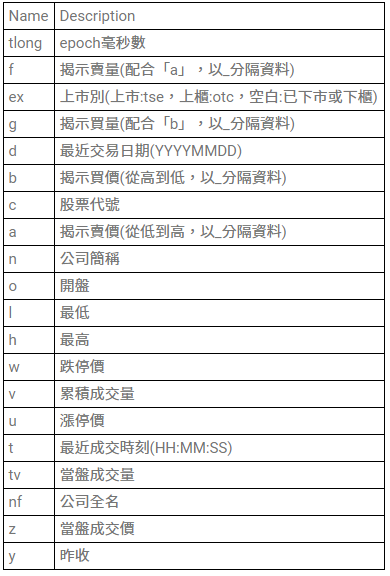

# 查詢歷史股價

In [43]:
import requests
from io import StringIO
import pandas as pd
import numpy as np

datestr = '20210513'

# 下載股價
# r = requests.post('https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + datestr + '&type=ALL')
# https://www.twse.com.tw/exchangeReport/MI_INDEX?response=json&date=20210514&type=ALL
r = requests.post('https://www.twse.com.tw/exchangeReport/MI_INDEX?response=json&date=' + datestr + '&type=ALL')

In [49]:
data = json.loads(r.text)
for i data

dict

In [32]:
url = 'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date=20200921&stockNo=2330'
data = requests.get(url).text
data

'{"stat":"OK","date":"20200921","title":"109年09月 2330 台積電           各日成交資訊","fields":["日期","成交股數","成交金額","開盤價","最高價","最低價","收盤價","漲跌價差","成交筆數"],"data":[["109/09/01","50,129,577","21,681,382,412","430.00","435.00","428.00","435.00","+8.50","17,137"],["109/09/02","42,013,407","18,268,716,092","441.00","441.00","430.50","433.00","-2.00","20,242"],["109/09/03","40,683,617","17,768,951,582","439.50","439.50","433.50","436.00","+3.00","17,810"],["109/09/04","51,349,911","22,051,596,821","427.00","432.50","427.00","429.00","-7.00","27,893"],["109/09/07","39,854,584","17,060,627,028","428.00","432.50","425.00","426.00","-3.00","20,003"],["109/09/08","23,714,670","10,208,232,440","428.00","433.00","427.50","431.00","+5.00","12,440"],["109/09/09","40,727,362","17,312,991,408","425.00","428.00","423.00","427.00","-4.00","21,740"],["109/09/10","35,281,921","15,275,112,115","432.50","435.00","430.50","435.00","+8.00","18,244"],["109/09/11","34,893,469","15,171,902,036","435.50","436.50","432.50","4

# 查詢即時股價

In [33]:
url = 'http://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=tse_1101.tw'

In [51]:
import requests
from bs4 import BeautifulSoup
url = 'http://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=tse_1101.tw'
# result = requests.get('https://opendata.cwb.gov.tw/api/v1/rest/datastore/F-C0032-001?Authorization=CWB-5B414EA1-34DB-4168-8B56-7EBFE0BBACCF')
result = requests.get(url)
print(result.status_code)
soup = BeautifulSoup(result.text,'html.parser')
data = json.loads(result.text)

print(data)

200
{'msgArray': [{'tv': '1676', 'ps': '1675', 'pz': '47.9000', 'oa': '48.0500', 'ob': '48.0000', 'a': '47.9500_48.0000_48.0500_48.1000_48.1500_', 'b': '47.9000_47.8500_47.8000_47.7500_47.7000_', 'c': '1101', 'd': '20210517', 'ch': '1101.tw', 'ot': '14:25:00', 'tlong': '1621232700000', 'f': '93_147_29_100_226_', 'ip': '0', 'g': '33_185_163_168_235_', 'mt': '000000', 'ov': '-', 'h': '49.0500', 'i': '01', 'it': '12', 'oz': '0.0000', 'l': '47.5000', 'n': '台泥', 'o': '47.8000', 'p': '0', 'ex': 'tse', 's': '1676', 't': '13:30:00', 'u': '54.5000', 'v': '52389', 'w': '44.6500', 'nf': '台灣水泥股份有限公司', 'y': '49.6000', 'z': '47.9000', 'ts': '0'}], 'referer': '', 'userDelay': 5000, 'rtcode': '0000', 'queryTime': {'sysDate': '20210517', 'stockInfoItem': 1933, 'stockInfo': 295578, 'sessionStr': 'UserSession', 'sysTime': '14:25:43', 'showChart': False, 'sessionFromTime': -1, 'sessionLatestTime': -1}, 'rtmessage': 'OK', 'exKey': 'if_tse_1101.tw_zh-tw.null', 'cachedAlive': 1653}


In [ ]:
https://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=tse_1101.tw&json=1&delay=0

In [132]:
def get_all_stock():
    import datetime
    import os.path
    from googleapiclient.discovery import build
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    from google.oauth2.credentials import Credentials
    import pandas as pd
    import re
    import gspread
    from oauth2client.service_account import ServiceAccountCredentials
    def save_to_gs():
        scopes = ["https://spreadsheets.google.com/feeds"]
        credentials = ServiceAccountCredentials.from_json_keyfile_name("credentials_gs.json", scopes)
        gc = gspread.authorize(credentials)
        sh = gc.open_by_key("1zwoDKbf4g8oUmS8oOu_RtdDa7G5kVVG_9ruu8VNtyKw")#stock
        stock_name = sh.worksheet("stock_name")
        return stock_name

    def get_list():
        url = 'https://isin.twse.com.tw/isin/C_public.jsp?strMode=2' # 上市全部代號
        result = requests.get(url)
        soup = BeautifulSoup(result.text,'html.parser')
        tr = soup.select('tr')

        list = []
        for i in tr[2:]:
            list_1=[]
            a=i.find('td').get_text()
            b=a.rsplit('\u3000', 1)
            if len(b) ==2:
                list_1.append(b[1])
                list_1.append(b[0])
            list.append(list_1)
        return list

    worksheet = save_to_gs()
    list = get_list()
    worksheet.update('A1', list)

In [134]:
def get_code(name): #取得股票代號
    try:
        cell = worksheet.find(name)
    except:
        pass
    if cell.col ==1:
        cell_code=worksheet.cell(cell.row, cell.col+1).value
    else:
        cell_code = name
    print(cell_code)
    return cell_code
get_code('聯電')

2303


In [127]:
starttime = datetime.datetime.now() #開始計算時間
get_code('鴻海')
endtime = datetime.datetime.now() #結束時間
print(endtime - starttime) #程式執行時間

2317
0:00:01.274854


In [81]:
dic

{'台泥': '1101',
 '亞泥': '1102',
 '嘉泥': '1103',
 '環泥': '1104',
 '幸福': '1108',
 '信大': '1109',
 '東泥': '1110',
 '味全': '1201',
 '味王': '1203',
 '大成': '1210',
 '大飲': '1213',
 '卜蜂': '1215',
 '統一': '1216',
 '愛之味': '1217',
 '泰山': '1218',
 '福壽': '1219',
 '台榮': '1220',
 '福懋油': '1225',
 '佳格': '1227',
 '聯華': '1229',
 '聯華食': '1231',
 '大統益': '1232',
 '天仁': '1233',
 '黑松': '1234',
 '興泰': '1235',
 '宏亞': '1236',
 '鮮活果汁-KY': '1256',
 '台塑': '1301',
 '南亞': '1303',
 '台聚': '1304',
 '華夏': '1305',
 '三芳': '1307',
 '亞聚': '1308',
 '台達化': '1309',
 '台苯': '1310',
 '國喬': '1312',
 '聯成': '1313',
 '中石化': '1314',
 '達新': '1315',
 '上曜': '1316',
 '東陽': '1319',
 '大洋': '1321',
 '永裕': '1323',
 '地球': '1324',
 '恆大': '1325',
 '台化': '1326',
 '再生-KY': '1337',
 '廣華-KY': '1338',
 '昭輝': '1339',
 '勝悅-KY': '1340',
 '富林-KY': '1341',
 '八貫': '1342',
 '遠東新': '1402',
 '新纖': '1409',
 '南染': '1410',
 '宏洲': '1413',
 '東和': '1414',
 '廣豐': '1416',
 '嘉裕': '1417',
 '東華': '1418',
 '新紡': '1419',
 '利華': '1423',
 '大魯閣': '1432',
 '福懋': '1434',
 '中福': '1435',


In [193]:
myNumber = 1.237437874376
myRoundNumber = round(myNumber, 2)
print(myRoundNumber)

1.24


In [16]:
a = '567.0000_568.0000_569.0000_570.0000_571.0000_'
a.split('_')[0]

'567.0000'

In [45]:
url='http://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=tse_2330.tw'
r=requests.get(url).text
today_json = json.loads(r)
today_json

{'msgArray': [{'tv': '3441',
   'ps': '3419',
   'pz': '572.0000',
   'fv': '413',
   'oa': '573.0000',
   'ob': '572.0000',
   'a': '572.0000_573.0000_574.0000_575.0000_576.0000_',
   'b': '571.0000_570.0000_569.0000_568.0000_567.0000_',
   'c': '2330',
   'd': '20210518',
   'ch': '2330.tw',
   'ot': '14:30:00',
   'tlong': '1621319400000',
   'f': '297_692_764_792_563_',
   'ip': '0',
   'g': '19_65_367_344_324_',
   'mt': '000000',
   'ov': '61316',
   'h': '573.0000',
   'i': '24',
   'it': '12',
   'oz': '572.0000',
   'l': '555.0000',
   'n': '台積電',
   'o': '563.0000',
   'p': '0',
   'ex': 'tse',
   's': '3441',
   't': '13:30:00',
   'u': '603.0000',
   'v': '43215',
   'w': '494.5000',
   'nf': '台灣積體電路製造股份有限公司',
   'y': '549.0000',
   'z': '572.0000',
   'ts': '0'}],
 'referer': '',
 'userDelay': 5000,
 'rtcode': '0000',
 'queryTime': {'sysDate': '20210518',
  'stockInfoItem': 2047,
  'stockInfo': 295902,
  'sessionStr': 'UserSession',
  'sysTime': '16:14:18',
  'showChart': 

In [2]:
!pip install TA-Lib

  Using cached TA-Lib-0.4.20.tar.gz (266 kB)
  Running setup.py clean for TA-Lib
Failed to build TA-Lib
    Running setup.py install for TA-Lib: started
    Running setup.py install for TA-Lib: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\devil\.conda\envs\linebot\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\devil\\AppData\\Local\\Temp\\pip-install-f1r3qp_x\\ta-lib_a9b027310ca64c72ad28bf8113949b50\\setup.py'"'"'; __file__='"'"'C:\\Users\\devil\\AppData\\Local\\Temp\\pip-install-f1r3qp_x\\ta-lib_a9b027310ca64c72ad28bf8113949b50\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\devil\AppData\Local\Temp\pip-wheel-rzrcdmu9'
       cwd: C:\Users\devil\AppData\Local\Temp\pip-install-f1r3qp_x\ta-lib_a9b027310ca64c72ad28bf8113949b50\
  Complete output (26 lines):
  C:\Users\devil\AppData\Local\Temp\pip-install-f1r3qp_x\ta-lib_a9b027310ca64c72ad28bf8113949b50\setup.py:7